# Pipeline Development

First draft of pipeline from loading to clusters. Final draft functions and classes were moved to the `fletchmod.py` module for use in the next phases, and updated as needed throughout the process. **Functions in this notebook are not necessarily indicitave of the final versions.**

In [474]:
import pandas as pd
import numpy as np
import json
from itertools import chain
from pymongo import MongoClient
from bson.objectid import ObjectId
import re
import pprint
from IPython import display

from spacy.en import STOP_WORDS
import spacy
from nltk.stem import (PorterStemmer,
                       LancasterStemmer,
                       SnowballStemmer,
                       RegexpStemmer as REStemmer,
                       WordNetLemmatizer
                      )

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering as Agg
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [3]:
# load collection
client = MongoClient()
p4_db = client.proj4
lyrics_coll = p4_db.lyrics

## 1. Pulling lyrics from DB

In [13]:
def lyrics_from_db(coll, sample_size='all', min_year=1965, max_year=1975):
    """
    Returns raw lyrics and corresponding BSON IDs for songs within the min 
    year/max year range (inclusive). Returns all songs in range, or a sample of
    given size.
    ---
    IN
    coll: MongoDB lyrics collection
    sample_size: number of songs in sample (int), or 'all' if all in range (str)
    min_year: lower bound for samples (int)
    max_year: upper bound for samples (int)
    OUT
    lyrics: list of raw lyrics (list)
    song_ids: list of BSON IDs corresponding with lyrics list (list)
    """
    
    if sample_size == 'all':
        docs = coll.find({'Year': {"$gte": min_year, "$lte": max_year},
                          'Lyrics': {"$exists": True}})
        
    else:
        assert type(sample_size) == int, "size must be an integer if not 'all'"
        docs = coll.aggregate([{"$match": 
                                {"$and": [{'Year': {"$gte": min_year, 
                                                    "$lte": max_year}},
                                          {'Lyrics': {"$exists": True}}
                                         ]}},
                               {"$sample": {"size": sample_size}}
                              ])
    
    lyrics = []
    song_ids = []
    for doc in docs:
        lyrics.append(doc['Lyrics'])
        song_ids.append(doc['_id'])
    
    return lyrics, song_ids

## 2. Cleaning Lyrics

To get an idea of what we might need to do in the cleaning process...

In [4]:
# pulls a sample from a specific date range

sample = lyrics_coll.aggregate([{"$match": {'Year': {"$gte": 1965, "$lte": 1975}}},
                           {"$sample": {"size": 20}}
                           ])

for record in sample:
    pprint.pprint(record)

{'Artist': 'bobby hebb',
 'Instrumental': False,
 'Lyrics': ' sunny yesterday my life was filled with rain sunny you smiled at '
           'me and really eased the pain now the dark days are gone and the '
           'bright days are here my sunny one shines so sincere sunny one so '
           'true i love yousunny thank you for the sunshine bouquet sunny '
           'thank you for the love you brought my way you gave to me your all '
           'and all and now i feel ten feet tall sunny one so true i love '
           'yousunny thank you for the truth you let me see sunny thank you '
           'for the facts from a to z my life was torn like windblown sand and '
           'a rock was formed when you held my hand oh sunny sunny one so true '
           'i love yousunny thank you for the smile upon your face hmm sunny '
           'thank you thank you for the gleam that shows its grace youre my '
           'spark of natures fire youre my sweet complete desire sunny one so '
     

**Lyric Issues**

1. Some songs include the header information, usually followed by several spaces
2. Some include pop-up text, other title info, sometimes separated by more than few spaces
3. Runnin v running (stemming should fix this)
4. Newlines were stripped and not replaced with a space, thus many words at the end of the line form compound words with those at the beginning of the next line
5. Potential misspellings
6. Excessive repetition of words

Removing header info and other forms of invasive text may be more difficult than actually re-scraping the data; same goes for the newline problem. Running everything through a spell-checker may transform these unintentionally compounded words into words that have nothing to do with the song whatsoever, same going for slang words. Binarizing the vectorizer would take care of excessive repetition, but may increase the strength of these compounded words as well.

I can do the following right off. This will need far more if I scrape my own...

In [12]:
def clean_it_up(words):
    """
    Cleaning operations necessary to clean document and prepare for
    tokenization.
    ---
    IN
    words: string to be cleaned (str)
    OUT
    words: cleaned string (str)
    """
    
    # remove any 'word' beginning with a number
    words = re.sub(r'\b\d+\S*\b', '', words)
    
    # remove swaths of whitespace, strip at beginning and end
    words = re.sub(r'\s+', ' ', words).strip()
    
    return words

In [27]:
def pull_and_clean_lyrics(coll, size):
    """
    Aggregate the lyrics_from_db() and clean_it_up() functions.
    *** As of now, cannot specify year range in this one, defaults of
    lyrics_from_db() are used. ***
    ---
    IN
    coll: MongoDB collection of songs
    size: number of songs in sample, or 'all' for all
    OUT
    lyrics_clean: list of cleaned lyrics (list of strs)
    song_ids: corresponding list of BSON IDs for each song (list)
    """
    
    raw_lyrics, song_ids = lyrics_from_db(coll, sample_size=size)
    
    clean_lyrics = []
    for lyric in raw_lyrics:
        clean_lyrics.append(clean_it_up(lyric))
        
    return clean_lyrics, song_ids

In [28]:
test_lyrics, test_ids = pull_and_clean_lyrics(lyrics_coll, size=10)

for ID, lyric in zip(test_ids, test_lyrics):
    print("Song ID:", ID)
    print(lyric, '\n')

Song ID: 59f903150f3e05a46c01d7ff
when a man loves a woman cant keep his mind on nothing else hell trade the world for the good thing hes found if shes bad he cant see it she can do no wrong turn his back on his best friend if he put her downwhen a man loves a woman spend his very last dime trying to hold on to what he needs hed give up all his comfort sleep out in the rain if she said thats the way it ought to bewell this man loves a woman i gave you everything i had trying to hold on to your precious love baby please dont treat me badwhen a man loves a woman down deep in his soul she can bring him such misery if she plays him for a fool hes the last one to know loving eyes cant ever seewhen a man loves a woman he can do no wrong he can never own some other girl yes when a man loves a woman i know exactly how he feels cause baby baby baby youre my worldwhen a man loves a woman 

Song ID: 59f903150f3e05a46c01daa8
im comin home ive done my time now ive got to know what is and isnt mine 

## 3. Tokenizing

In [23]:
nlp = spacy.load('en')

In [13]:
unchained = lyrics.find_one({"Song": "unchained melody"})
um_lyrics = clean_it_up(unchained['Lyrics'])

um_doc = nlp(um_lyrics)

In [19]:
for word in um_doc:
    print((word,word.pos_, word.lemma_))

(oh, 'INTJ', 'oh')
(my, 'ADJ', '-PRON-')
(love, 'NOUN', 'love')
(my, 'ADJ', '-PRON-')
(darling, 'NOUN', 'darling')
(i, 'PRON', '-PRON-')
(ve, 'VERB', 'have')
(hungered, 'NUM', 'hungered')
(for, 'ADP', 'for')
(your, 'ADJ', '-PRON-')
(touch, 'NOUN', 'touch')
(a, 'DET', 'a')
(long, 'ADJ', 'long')
(lonely, 'ADJ', 'lonely')
(time, 'NOUN', 'time')
(time, 'NOUN', 'time')
(goes, 'VERB', 'go')
(by, 'ADV', 'by')
(so, 'ADV', 'so')
(slowly, 'ADV', 'slowly')
(and, 'CCONJ', 'and')
(time, 'NOUN', 'time')
(can, 'VERB', 'can')
(do, 'VERB', 'do')
(so, 'ADV', 'so')
(much, 'ADV', 'much')
(are, 'VERB', 'be')
(you, 'PRON', '-PRON-')
(still, 'ADV', 'still')
(mine, 'PRON', '-PRON-')
(i, 'PRON', 'i')
(need, 'VERB', 'ne')
(your, 'ADJ', '-PRON-')
(love, 'NOUN', 'love')
(i, 'PRON', 'i')
(need, 'VERB', 'ne')
(your, 'ADJ', '-PRON-')
(love, 'NOUN', 'love')
(god, 'ADJ', 'god')
(speed, 'NOUN', 'speed')
(your, 'ADJ', '-PRON-')
(love, 'NOUN', 'love')
(to, 'ADP', 'to')
(me, 'PRON', '-PRON-')
(meaning, 'VERB', 'mean')
(by

In [39]:
def look_at_words(mongo_sample):
    """
    Cycles through a sample of lyrics and shows word, word.pos_,
    and word.lemma_ for each song.
    """
    
    for song in mongo_sample:
        print(f"Song: {song['Song']}\n")
        print("WORD / POS / LEMMA\n")
        lyrics = clean_it_up(song['Lyrics'])
        lyrics_doc = nlp(lyrics)
        for word in lyrics_doc:
            print((word, word.pos_, word.lemma_)) 
        input("\n-- Enter to continue --\n")

In [70]:
look_at_words(sample_lyrics(20))

Song: keep searchin well follow the sun

WORD / POS / LEMMA

(no, 'DET', 'no')
(one, 'NOUN', 'one')
(will, 'VERB', 'will')
(understand, 'VERB', 'understand')
(what, 'NOUN', 'what')
(i, 'PRON', '-PRON-')
(ve, 'VERB', 'have')
(got, 'VERB', 'get')
(ta, 'PART', 'ta')
(do, 'VERB', 'do')
(i, 'PRON', '-PRON-')
(ve, 'VERB', 'have')
(got, 'VERB', 'get')
(ta, 'PART', 'ta')
(find, 'VERB', 'find')
(a, 'DET', 'a')
(place, 'NOUN', 'place')
(to, 'PART', 'to')
(hide, 'VERB', 'hide')
(with, 'ADP', 'with')
(my, 'ADJ', '-PRON-')
(baby, 'NOUN', 'baby')
(by, 'ADP', 'by')
(my, 'ADJ', '-PRON-')
(side, 'NOUN', 'side')
(she, 'PRON', '-PRON-')
(s, 'VERB', 's')
(been, 'VERB', 'be')
(hurt, 'ADV', 'hurt')
(so, 'ADV', 'so')
(much, 'ADV', 'much')
(they, 'PRON', '-PRON-')
(treat, 'VERB', 'treat')
(her, 'PRON', '-PRON-')
(mean, 'ADJ', 'mean')
(and, 'CCONJ', 'and')
(cruel, 'ADJ', 'cruel')
(they, 'PRON', '-PRON-')
(try, 'VERB', 'try')
(to, 'PART', 'to')
(keep, 'VERB', 'keep')
(us, 'PRON', '-PRON-')
(far, 'ADV', 'far')
(

KeyboardInterrupt: 

### Tuning the Clean/Tokenization Process

On an initial sprint to vectorization, slang, phonetic representations, and the compound problem were potentially contributing to a messy bunch of vectors. I'll try to clean this up a bit more.

"Brown Eyed Girl" has a bunch of the -in' gerunds...

In [136]:
browneyedgirl = lyrics_coll.find_one({"Song": "brown eyed girl"})
beg_lyrics = clean_it_up(browneyedgirl['Lyrics'])

In [233]:
print(beg_lyrics)

hey where did we go days when the rains came down in the hollow playin a new gamelaughin and arunnin hey hey skippin and ajumpin in the misty mornin fog with our our hearts athumpinand you my brown eyed girl you my brown eyed girland whatever happened to tuesday and so slow going down the old man with a transistor radiostandin in the sunlight laughin hidin behind a rainbows wall slippin and aslidin all along the waterfallwith you my brown eyed girl you my brown eyed girldo you remember when we used to sing sha la la la la la la la la lla te da just like that sha la la la la la la la la lla te da la te daso hard to find my way now that im all on my own i saw you just the other day my how you have growncast my memory back there lord sometimes im overcome thinkin bout it makin love in the green grass behind the stadium with you my brown eyed girl you my brown eyed girldo you remember when we used to sing sha la la la la la la la la lla te da lyin in the green grass sha la la la la la la l

To take a closer look at how the various stemmer types perform: 

In [156]:
stemmers = [PorterStemmer(), 
            LancasterStemmer(), 
            SnowballStemmer('english')
           ]
stem_names = ['Porter', 'Lancaster', 'Snowball']

for name, stemmer in zip(stem_names, stemmers):
    lyric_list = []
    for word in beg_lyrics.split(' '):
        lyric_list.append(stemmer.stem(word))
    print(f"\n{name}:")
    print(lyric_list)


Porter:
['hey', 'where', 'did', 'we', 'go', 'day', 'when', 'the', 'rain', 'came', 'down', 'in', 'the', 'hollow', 'playin', 'a', 'new', 'gamelaughin', 'and', 'arunnin', 'hey', 'hey', 'skippin', 'and', 'ajumpin', 'in', 'the', 'misti', 'mornin', 'fog', 'with', 'our', 'our', 'heart', 'athumpinand', 'you', 'my', 'brown', 'eye', 'girl', 'you', 'my', 'brown', 'eye', 'girland', 'whatev', 'happen', 'to', 'tuesday', 'and', 'so', 'slow', 'go', 'down', 'the', 'old', 'man', 'with', 'a', 'transistor', 'radiostandin', 'in', 'the', 'sunlight', 'laughin', 'hidin', 'behind', 'a', 'rainbow', 'wall', 'slippin', 'and', 'aslidin', 'all', 'along', 'the', 'waterfallwith', 'you', 'my', 'brown', 'eye', 'girl', 'you', 'my', 'brown', 'eye', 'girldo', 'you', 'rememb', 'when', 'we', 'use', 'to', 'sing', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'just', 'like', 'that', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'la', 'te', 'daso', 'hard', 'to', 'find', 

None of the stemmers catch the slang gerund form... one solution could be RE:

In [135]:
st = REStemmer('in$', min=5)
st.stem('walkin')

'walk'

Inserting this into the spacy_tokenizer() function right before the main stemmer yields the following:

In [163]:
beg_tokens = spacy_tokenizer(beg_lyrics)
print(beg_tokens)

['hey', 'day', 'rain', 'came', 'hollow', 'play', 'new', 'gamelaugh', 'arunn', 'hey', 'hey', 'skipp', 'ajump', 'misti', 'morn', 'fog', 'heart', 'athumpinand', 'brown', 'eye', 'girl', 'brown', 'eye', 'girland', 'happen', 'tuesday', 'slow', 'go', 'old', 'man', 'transistor', 'radiostand', 'sunlight', 'laugh', 'hid', 'rainbow', 'wall', 'slipp', 'aslid', 'waterfallwith', 'brown', 'eye', 'girl', 'brown', 'eye', 'girldo', 'rememb', 'sing', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'like', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'la', 'te', 'daso', 'hard', 'find', 'way', 'm', 'saw', 'day', 'growncast', 'memori', 'lord', 'm', 'overcom', 'think', 'bout', 'mak', 'love', 'green', 'grass', 'stadium', 'brown', 'eye', 'girl', 'brown', 'eye', 'girldo', 'rememb', 'sing', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'lyin', 'green', 'grass', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'd

In [204]:
beg_tokens2 = spacy_tokenizer(beg_lyrics, stemmer=LancasterStemmer())
print(beg_tokens2)

['hey', 'day', 'rain', 'cam', 'hollow', 'play', 'new', 'gamelaugh', 'arun', 'hey', 'hey', 'skip', 'ajump', 'misty', 'morn', 'fog', 'heart', 'athumpinand', 'brown', 'ey', 'girl', 'brown', 'ey', 'girland', 'hap', 'tuesday', 'slow', 'going', 'old', 'man', 'transist', 'radiostand', 'sunlight', 'laugh', 'hid', 'rainbow', 'wal', 'slip', 'aslid', 'waterfallwi', 'brown', 'ey', 'girl', 'brown', 'ey', 'girldo', 'rememb', 'sing', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'lik', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'la', 'te', 'daso', 'hard', 'find', 'way', 'm', 'saw', 'day', 'growncast', 'mem', 'lord', 'm', 'overcom', 'think', 'bout', 'mak', 'lov', 'green', 'grass', 'stad', 'brown', 'ey', 'girl', 'brown', 'ey', 'girldo', 'rememb', 'sing', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'lyin', 'green', 'grass', 'sha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'lla', 'te', 'da', 'bit', 'bit', 'bit'

Lancaster seems to be a little more aggressive in this case, turning 'slipping' into 'slip' instead of 'slipp', as with Porter.

#### A spell-checker?

Another solution could be a spell-checker/correcter which catches the -in' gerund cases and compound words, and attempts to correct them.

In [212]:
from nltk.metrics.distance import edit_distance
import enchant
eng_dict = enchant.Dict("en_US")

In [237]:
def show_ed(word):
    alts = eng_dict.suggest(word)
    ed = edit_distance(word, alts[0])
    print(f"{word} --> {alts[0]}: {str(ed)}")

In [335]:
eng_dict.check('running')

True

In [336]:
eng_dict.check('runnin')

False

In [345]:
show_ed('runnin')

runnin --> running: 1


In [244]:
edit_distance('aslidin', 'sliding')

2

In [344]:
show_ed('aslidin')

aslidin --> abiding: 3


In [341]:
eng_dict.suggest('aslidin')

['abiding', 'landslid', 'Alidia', 'Aspidiske']

In [346]:
show_ed('slidin')

slidin --> sliding: 1


In [342]:
eng_dict.suggest('slidin')

['sliding', 'slid in', 'slider', 'slide', 'slid', 'solidi']

In [377]:
# eng_dict = enchant.Dict("en_US")
# from nltk.metrics.distance import edit_distance

def spell_checker(word, min_ed=2, keep_fails=False):
    """
    Runs several spell-checking operations to clean up issues in the text.
    
    *** Must define eng_dict and edit_distance in the global space! ***
    ---
    IN
    word: word to be spell-checked (str)
    min_ed: minimum edit distance to replace word (int)
    keep_fails: if True, keep words even if none of the replacement methods
        have worked; if False, delete them (bool)
    OUT
    word_checked: list of checked words (list of strs) 
    """

    # no further processes need to run if it's a recognizable word
    if eng_dict.check(word.lower()):
        return word

    # otherwise...
    try:
        alts = eng_dict.suggest(word.lower())
        ed = edit_distance(word, alts[0])

        # can word be edited in min edit distance?
        if ed <= min_ed:
            return alts[0].lower()
        # try with proper gerund form (e.g. 'runnin' > 'running')
        elif word[-1] == 'n':
            return spell_checker(word + 'g')
        # try with leading character removed
        elif ed == min_ed + 1 and len(word) > 1:
            return spell_checker(word[1:])
        elif keep_fails:
            return word
        else:
            return None
        
    except IndexError:
        print(f"IndexError while trying to check '{word}'")
        return None

    
def check_word_list(words, keep_fails=False):
    """
    Feeds word list to spell checker, reassembles, returns.
    
    *** Must import chain from collections! ***
    ---
    IN
    words: words (strs) to be spell-checked (list)
    keep_fails: if True, keep words even if none of the replacement methods
        have worked; if False, delete them (bool)
    OUT
    checked: list of checked/corrected words (list)
    """
    
    checked = []
    
    for word in words:
        new = spell_checker(word, keep_fails=keep_fails)
        if new:
            checked = list(chain(checked, new.split(' ')))

    return checked


def check_word_string(doc, keep_fails=False):
    """
    Wrapper for check_word_list(), takes and returns a string of 
    component words.
    
    *** Must import chain from collections! ***
    ---
    IN
    doc: words to be spell-checked (str)
    keep_fails: if True, keep words even if none of the replacement methods
        have worked; if False, delete them (bool)
    OUT
    string of checked/corrected words (str)
    """

    checked = check_word_list(doc.split(' '), keep_fails=keep_fails)
    
    return ' '.join(checked)
    
    
def split_word(word, min_len=3):
    """
    Attempts to find a meaningful split of a falsely compounded word.
    ---
    IN
    word: word to split (str)
    min_len: minimum length of first word (int)
    OUT
    word: new string, either original word or successfully-split word (str)
    """
    pass

In [354]:
beg_checked = check_word_list(beg_lyrics.split(' '))
print("Raw length:", len(beg_lyrics.split(' ')))
print("Checked length:", len(beg_checked))
print(beg_checked)

Raw length: 271
Checked length: 276
['hey', 'where', 'did', 'we', 'go', 'days', 'when', 'the', 'rains', 'came', 'down', 'in', 'the', 'hollow', 'plain', 'a', 'new', 'game', 'laughing', 'and', 'running', 'hey', 'hey', 'skipping', 'and', 'jumping', 'in', 'the', 'misty', 'morning', 'fog', 'with', 'our', 'our', 'hearts', 'you', 'my', 'brown', 'eyed', 'girl', 'you', 'my', 'brown', 'eyed', 'garland', 'whatever', 'happened', 'to', 'tuesday', 'and', 'so', 'slow', 'going', 'down', 'the', 'old', 'man', 'with', 'a', 'transistor', 'radio', 'standing', 'in', 'the', 'sunlight', 'laughing', 'hiding', 'behind', 'a', 'rainbows', 'wall', 'slipping', 'and', 'sliding', 'all', 'along', 'the', 'waterfall', 'with', 'you', 'my', 'brown', 'eyed', 'girl', 'you', 'my', 'brown', 'eyed', 'girl', 'do', 'you', 'remember', 'when', 'we', 'used', 'to', 'sing', 'ha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'all', 'ch', 'da', 'just', 'like', 'that', 'ha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'all', 'ch'

Much cleaner after the spell check. Five words lost because the spell checker couldn't parse them. A couple obvious mistakes, such as 'garland' instead of 'girland', and 'mi' for 'im.' To the former, 'garland' was the first option in the suggestion list despite having the same edit distance as 'girl and,' a mistake bound to be made if edit distance is the only criteria for substitution. To the latter, I'll add it to stopwords or create an exceptions list in the chcker, since it'll be fairly common, as I'll do with anything that seems to throw off the vectors later on.

In [364]:
# nlp = spacy.load('en')

new_stopwords = ['im', 'mi']

for new in new_stopwords:
    STOP_WORDS.add(new)

def spacy_tokenizer(text,
                    spell_check=True,
                    stemmer=LancasterStemmer(),
                    stopwords=STOP_WORDS, 
                    punctuations=''):
    """
    Basic tokenizer based on Spacy doc object.
    
    *** Must spawn nlp object from spacy in global space! ***
    ---
    IN
    text: string of text to tokenize (str)
    spell_check: perform spell check function if True (bool)
    stemmer: stemmer object of choice
    stopwords: stopwords to omit from final list of tokens (set, list)
    punctuations: punctuation to omit from final tokens (set, list)
    OUT
    tokens: final list of word tokens
    """
    
    tokens = nlp(text)

#     tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" 
#                                          else tok.lower_ 
#                                          for tok in tokens]
    # or simply make list of words
    tokens = [tok.lower_ for tok in tokens]
    # spell check to clean up gerund and compound issues
    if spell_check:
        tokens = check_word_list(tokens)
    # remove if a stopword or punctuation
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]
    # stem remaining words
    tokens = [stemmer.stem(tok) for tok in tokens]
    
    return tokens

In [375]:
beg_tokens = spacy_tokenizer(beg_lyrics)
print(beg_tokens)

['hey', 'day', 'rain', 'cam', 'hollow', 'plain', 'new', 'gam', 'laugh', 'run', 'hey', 'hey', 'skip', 'jump', 'misty', 'morn', 'fog', 'heart', 'brown', 'ey', 'girl', 'brown', 'ey', 'garland', 'hap', 'tuesday', 'slow', 'going', 'old', 'man', 'transist', 'radio', 'stand', 'sunlight', 'laugh', 'hid', 'rainbow', 'wal', 'slip', 'slid', 'waterfal', 'brown', 'ey', 'girl', 'brown', 'ey', 'girl', 'rememb', 'sing', 'ha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'ch', 'da', 'lik', 'ha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'ch', 'da', 'la', 'ch', 'hard', 'find', 'way', 'm', 'saw', 'day', 'grown', 'cast', 'mem', 'lord', 'm', 'overcom', 'think', 'bout', 'akin', 'lov', 'green', 'grass', 'stad', 'brown', 'ey', 'girl', 'brown', 'ey', 'girl', 'rememb', 'sing', 'ha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'ch', 'da', 'yin', 'green', 'grass', 'ha', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'la', 'ch', 'da', 'bit', 'bit', 'bit', 'bit', 'bit', 'bit', 'ha', 'la', 'la', 'la', 'la', 

**NOTE:** I will be moving spell check to the cleaning function for the next notebooks, given the time it takes to do so and the ability to save cleaned lyrics in each MongoDB document.

## 5. Vectorization

### Sample Preparation

In [360]:
sample_lyrics, sample_ids = pull_and_clean_lyrics(lyrics_coll, size='all')

In [361]:
for i in range(5):
    print("Song ID:", sample_ids[i])
    print(sample_lyrics[i][:200], '\n')

Song ID: 59f903140f3e05a46c01d788
sugar pie honey bunch you know that i love you i cant help myself i love you and nobody elsein and out my life you come and you go leaving just your picture behind and i kissed it a thousand timeswhen 

Song ID: 59f903140f3e05a46c01d789
you never close your eyes anymore when i kiss your lips and theres no tenderness like before in your fingertips youre trying hard not to show it but baby baby i know ityou lost that lovin feelin whoa  

Song ID: 59f903140f3e05a46c01d78a
sam the sham miscellaneous wooly bully wooly bully sam the sham the pharaohs domingo samudio uno dos one two tres quatro matty told hatty about a thing she saw had two big horns and a wooly jaw wooly  

Song ID: 59f903140f3e05a46c01d78b
help i need somebody help not just anybody help you know i need someone help when i was younger so much younger than today i never needed anybodys help in any way but now these days are gone im not so 

Song ID: 59f903140f3e05a46c01d78c
carterlewis every 

### Let's Vectorize

In [38]:
def return_vec_data(text, vectorizer):
    """
    IF a Pandas dataframe is needed...
    Vectorizes a list of text strings with the vectorizer of choice,
    returns the sparse matrix created by the vectorizer, a pandas
    dataframe, and the fit vectorizer object.
    ---
    IN
    text: list of text strings (list)
    vectorizer: pre-spawned vectorizer object
    """
    
    vec_data = vectorizer.fit_transform(text)
    vec_df = (pd.DataFrame(vec_data.toarray(), 
                       columns=vectorizer.get_feature_names()))
    
    return vec_data, vec_df, vectorizer

In [ ]:
# if not set above
# nlp = spacy.load('en')

In [366]:
sample_cv = CountVectorizer(tokenizer=spacy_tokenizer, 
                                   ngram_range=(1,2),
                                   # max_features=1000,
                                   # stop_words='english', 
                                   # token_pattern="\\b[a-z][a-z]+\\b",
                                   # lowercase=True,
                                   binary=True,
                                   max_df=0.6
                                   #min_df=0.02
                           )

# sample_tf = TfidfVectorizer(tokenizer=spacy_tokenizer, 
#                                    ngram_range=(1,2), 
#                                    max_features=1000,  
#                                    # stop_words='english', 
#                                    # token_pattern="\\b[a-z][a-z]+\\b",
#                                    # lowercase=True,
#                                    max_df = 0.6)

In [376]:
sample_data_cv = sample_cv.fit_transform(sample_lyrics)
#sample_data_tf = sample_tf.fit_transform(sample_lyrics)

IndexError while trying to check '̢shotgun'
IndexError while trying to check 'hey̢'
IndexError while trying to check '̢buy'
IndexError while trying to check 'now̢'
IndexError while trying to check '̢shotgun'
IndexError while trying to check 'hey̢'
IndexError while trying to check '̢its'
IndexError while trying to check 'time̢'
IndexError while trying to check '̢its'
IndexError while trying to check 'time̢'
IndexError while trying to check '̢its'
IndexError while trying to check 'time̢'
IndexError while trying to check 'slaycrewetook'
IndexError while trying to check 'eyesahahahahah'
IndexError while trying to check 'shadeahahahahah'
IndexError while trying to check 'ooooohbut'
IndexError while trying to check 'ooooohcause'
IndexError while trying to check 'ooooohhow'
IndexError while trying to check 'ahhhhhhhhhhhhhhhhhhhhhhhh'
IndexError while trying to check 'ahhhhhhhhhhhhhhhhhhhhhhhhh'
IndexError while trying to check 'tmazanec1junocom'
IndexError while trying to check 'ronhontzworld

IndexError while trying to check 'ooooooooh'
IndexError while trying to check '̫i'
IndexError while trying to check 'or̫r̫i'
IndexError while trying to check 'r̫r̫r̫i'
IndexError while trying to check 'r̫r̫r̫i'
IndexError while trying to check 'r̫r̫r̫i'
IndexError while trying to check 'r̫r̫r̫i'
IndexError while trying to check 'ohror̫'
IndexError while trying to check 'pop̫'
IndexError while trying to check 'y̫i'
IndexError while trying to check 'or̫r̫i'
IndexError while trying to check 'r̫r̫r̫i'
IndexError while trying to check 'r̫'
IndexError while trying to check 'ooooooooh'
IndexError while trying to check 'h������'
IndexError while trying to check 'toodlieadatoot'
IndexError while trying to check 'toodliatatoodliata'
IndexError while trying to check 'aaaaaaaah'
IndexError while trying to check 'tearyeyeddont'
IndexError while trying to check 'wwwmp3lyricsorg'
IndexError while trying to check 'sweettaikingladies'
IndexError while trying to check 'caf̣'
IndexError while trying to c

In [390]:
sample_data_cv.shape

(1026, 48175)

## 6. Dimensionality Reduction

In [49]:
def display_topics(topic_model, feature_names, no_top_words, topic_names=None):
    for ind, topic in enumerate(topic_model.components_):
        if not topic_names or not topic_names[ind]:
            print("\nTopic ", ind)
        else:
            print("\nTopic: '",topic_names[ind],"'")
        print(", ".join([feature_names[i]
                         for i in topic.argsort()[:-no_top_words - 1:-1]]))

Eventually we'll try LSA/NMF, and maybe LDA, but now, we start with LSA.

In [582]:
test = TruncatedSVD(n_components=10, random_state=23)

In [409]:
n_comp = 50

In [410]:
lsa_cv = TruncatedSVD(n_components=n_comp, random_state=23)
# nmf_cv = NMF(n_components=n_comp, random_state=23)
# lsa_tf = TruncatedSVD(n_components=n_comp, random_state=23)
# nmf_tf = NMF(n_components=n_comp, random_state=23)

In [411]:
lsa_cv_data = lsa_cv.fit_transform(sample_data_cv)
# nmf_cv_data = nmf_cv.fit_transform(sample_data_cv)

In [383]:
display_topics(lsa_cv, sample_cv.get_feature_names(), 10)


Topic  0
lov, know, s, m, got, oh, lik, tim, e, com

Topic  1
away, man, cam, look, night, day, old, sing, hom, left

Topic  2
got, yeah, ai nt, ai, right, man, ta, m, got ta, said

Topic  3
oh, baby, yeah, good, sweet, said, girl, dant, tel, oh yeah

Topic  4
e, know, tel, got, away, caus, e got, m, d, heart

Topic  5
want, ey, lov, said, lik, look, leav, tel, d, right

Topic  6
let, com, e, lik, think, tel, quo, ll, quo nt, lov

Topic  7
com, tim, yeah, try, il, e, long, feel, hard, right

Topic  8
s, liv, ai nt, ai, world, lif, lov, tel, tim, think

Topic  9
e, got, e got, lov, ai, ai nt, lif, ey, hold, heart

Topic  10
quo, quo nt, oh, tim, long, cry, light, right, ey, ai nt

Topic  11
e, oh, lik, ey, good, e got, tim, feel, d, let

Topic  12
know, s, girl, littl, got, ta, com, got ta, day, baby

Topic  13
oh, find, man, quo nt, quo, liv, il, lov, girl, got

Topic  14
know, let, lik, long, away, girl, nt know, tim, d, quo nt


In [384]:
display_topics(nmf_cv, sample_cv.get_feature_names(), 10)


Topic  0
lov, know, tel, want, heart, m, il, nee, tim, s

Topic  1
away, day, way, hom, left, stay, cam, leav, night, run

Topic  2
got, e, e got, ta, got ta, m, know, ai, ai nt, let

Topic  3
play, oh, mus, word, night, good, dant, deep, went, cam

Topic  4
lik, look, said, m, s, man, know, got, littl, right

Topic  5
caus, knew, ey, leav, yeah, thought, said, run, try, hat

Topic  6
baby, oh, yeah, feel, m, oh yeah, hey, good, right, ooh

Topic  7
s, world, liv, find, day, lif, mind, plac, peopl, tim

Topic  8
com, tim, right, s, il, m, long, try, look, night

Topic  9
long, oh, car, caus, sur, il, going, mind, tim, high

Topic  10
lov, lik, ey, dream, night, hand, hold, clos, sweet, walk

Topic  11
ai nt, ai, s, let, night, light, nt know, know, stop, shin

Topic  12
quo, quo nt, oh, let, know, light, lov, ll, find, s

Topic  13
song, sing, man, know, old, rock, rol, ai nt, ai, nt know

Topic  14
caus, ai nt, ai, friend, night, man, hom, right, thing, way


In [88]:
# getting an error...
# display_topics(lsa_tf, sample_tf.get_feature_names(), 10)


Topic  0


IndexError: list index out of range

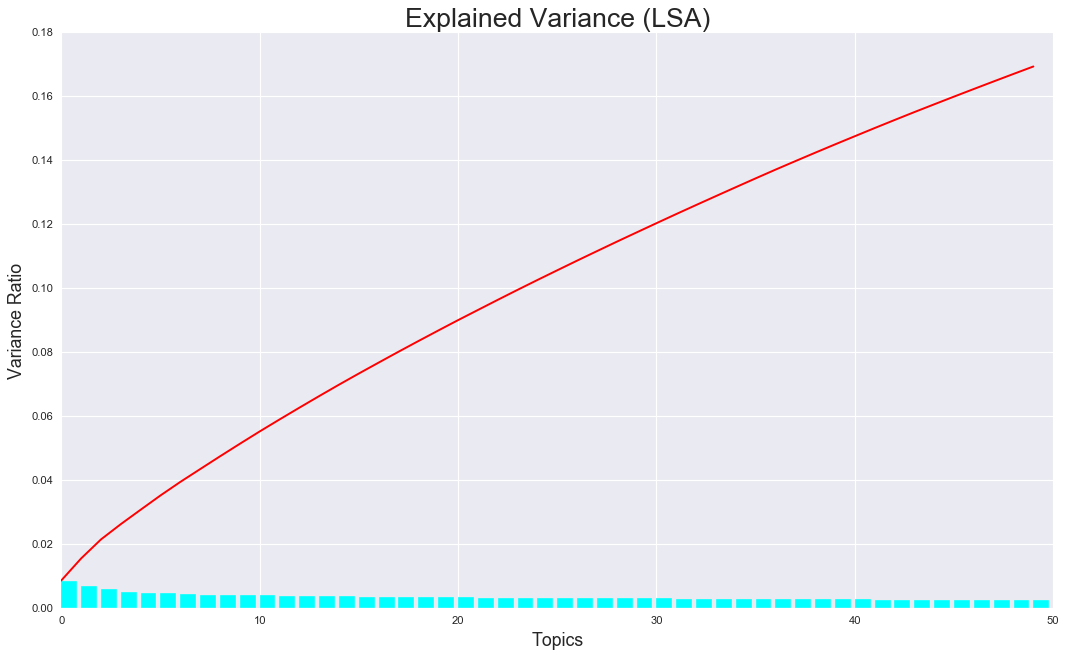

In [453]:
x = np.arange(n_comp)
y_lsa = lsa_cv.explained_variance_ratio_
# y_nmf = nmf_cv.explained_variance_ratio_

# fig, ax = plt.subplots(1, 2, figsize=(16,9))
                       
# fig.suptitle("Explained Variance per Topic", fontsize=24)
# fig.subtitle("Topics", fontsize=16)
# fig.ylabel("Proportion of Variance")

# ax[0].bar(x, y_lsa, color="cyan")
# ax[0].plot(np.cumsum(y_lsa),'b')
# ax[0].set_title("LSA")

# ax[1].bar(x, y_nmf, color="cyan")
# ax[1].plot(np.cumsum(y_nmf),'b')
# ax[1].set_title("NMF")

plt.figure(figsize=(16,9))
plt.bar(x, y, color="cyan")
plt.plot(np.cumsum(y),'r')
plt.xlabel('Topics', fontsize=16)
plt.ylabel('Variance Ratio', fontsize=16)
plt.title('Explained Variance (LSA)', fontsize=24);
#plt.grid()  fig1.text(0.80, .8, 'p = {:1f}'.format(pdr[1]), fontsize=12);

In [481]:
print(plt.style.available)

['_classic_test', 'bmh', 'classic', 'dark_background', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn']


## 7. Reduce to 3D and Cluster for Viz

Becuase it does not make sense to cluster in 3D space to get an idea of what clustering might be like in higher dimensional space, none of this was used in the final presentation. However, it was a good exercise in 3D plotting from several angles...

In [526]:
lsa_cv_data.shape

(1026, 50)

In [541]:
lsa_cv_3d = TruncatedSVD(n_components=3)
lsa_3d_data = lsa_cv_3d.fit_transform(lsa_cv_data)

In [542]:
for col in lsa_3d_data.T:
    print('\nMin:', col.min())
    print('Max:', col.max())
    print('Mean:', col.mean())
    print('SD:', col.std())


Min: -9.57189229323e-22
Max: 6.14588112516
Mean: 2.18550564046
SD: 0.907628136929

Min: -2.30980264504
Max: 8.60994284072
Mean: 0.0102385774699
SD: 0.817280670486

Min: -3.56521691527
Max: 3.76279197311
Mean: 0.0497642135535
SD: 0.758742414415


In [ ]:
# ss_3d = StandardScaler()
# lsa_3d_scaled = ss_3d.fit_transform(lsa_3d_data)

In [567]:
def plot_clusters_3D(X, y, figx, figy, azimuth=130):
    
    fig = plt.figure(1, figsize=(figx, figy))
    plt.style.use('seaborn-whitegrid')
    # this is the 'right' way to do it, so they say
    # ax = fig.add_subplot(111, projection='3d')
    ax = Axes3D(fig, elev=-160, azim=azimuth)
    ax.scatter(X[:, 0], 
               X[:, 1], 
               X[:, 2],
               c=y, 
               cmap=plt.cm.Set1
              )
    ax.set_title("Lyrics in 3D")
    ax.set_xlabel("X1")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("X2")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("X3")
    ax.w_zaxis.set_ticklabels([])

    plt.show()

In [559]:
# this does not work, sadly

# def plot_clusters_3Dx4(X, y, figx, figy, az_start=30):
    
#     fig, ax = plt.subplots(2, 2, figsize=(figx, figy))
#     plt.style.use('seaborn-whitegrid')
#     az = az_start
#     for i in range(2):
#         for j in range(2):
#             fig = plt.figure(1, figsize=(figx/2, figy/2))
#             ax[i][j] = Axes3D(fig, elev=-160, azim=az)
#             ax[i][j].scatter(X[:, 0], 
#                              X[:, 1], 
#                              X[:, 2],
#                              c=y, 
#                              cmap=plt.cm.Set1
#                             )
#             ax[i][j].set_title("Lyrics in 3D")
#             ax[i][j].set_xlabel("X1")
#             ax[i][j].w_xaxis.set_ticklabels([])
#             ax[i][j].set_ylabel("X2")
#             ax[i][j].w_yaxis.set_ticklabels([])
#             ax[i][j].set_zlabel("X3")
#             ax[i][j].w_zaxis.set_ticklabels([])
#             az += 90

1 Clusters:
[1026]


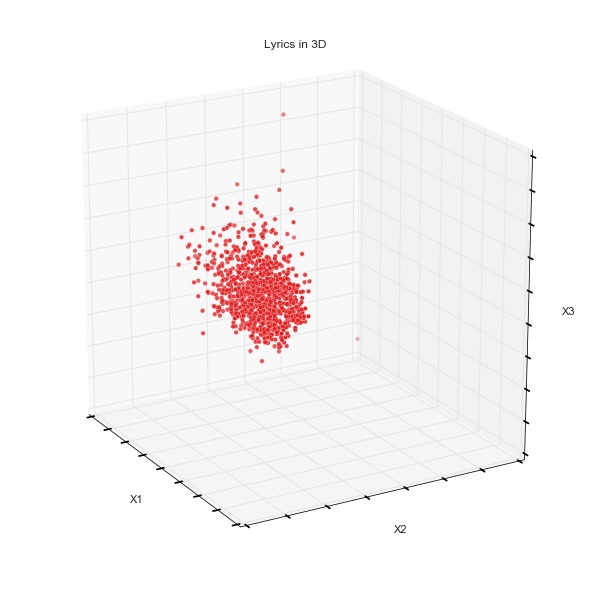

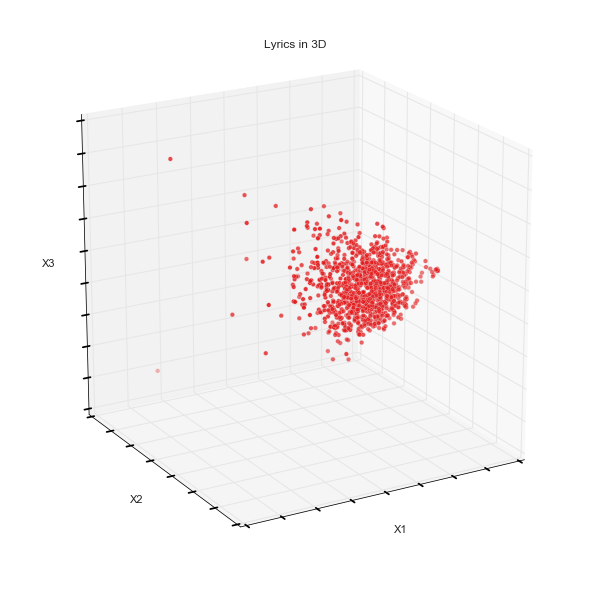

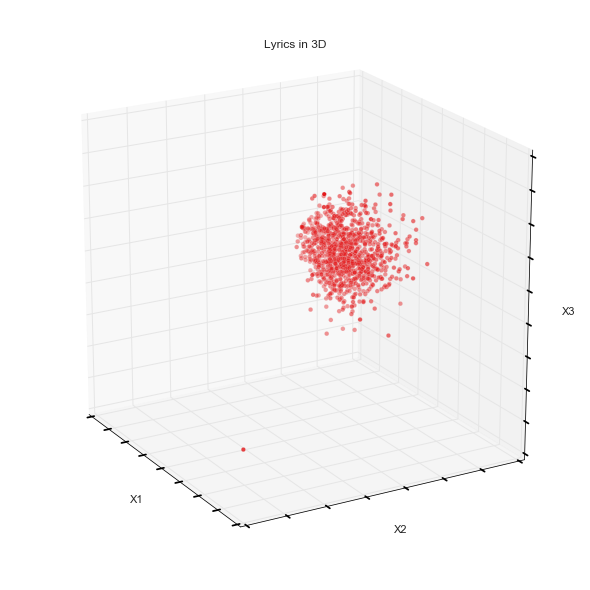

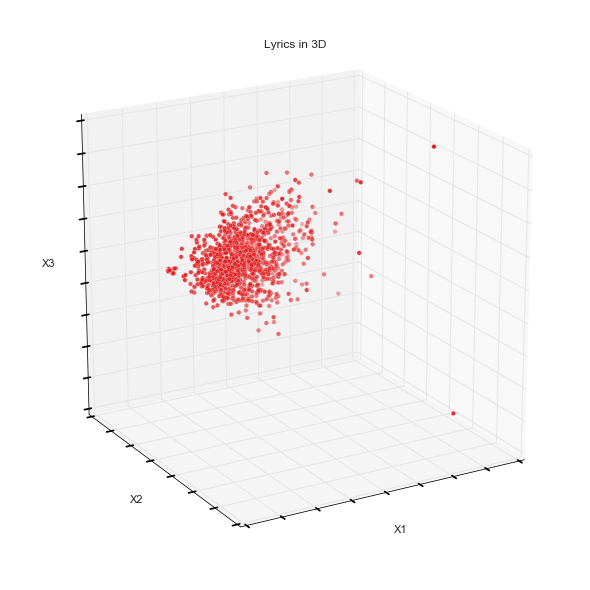

Hit enter to continue


In [572]:
for n in range(1,2):
    display.clear_output()
    agg = Agg(n_clusters=n)
    clusters_3d = agg.fit_predict(lsa_3d_data)
    print(f"{n} Clusters:")
    print(np.bincount(clusters_3d))
#     plot_clusters_3Dx4(lsa_3d_data, clusters_3d, 16, 16, az_start=30)
    for az in [30, 120, 210, 300]:
        plot_clusters_3D(lsa_3d_data, clusters_3d, 8, 8, azimuth=az)    
    input('Hit enter to continue') 


## 8. Let's Make Cluster

A first pass to see what clusters "look" like in topic space.

In [573]:
ss_lsa = StandardScaler()
ss_nmf = StandardScaler()

In [574]:
lsacv_scaled = ss_lsa.fit_transform(lsa_cv_data)
nmfcv_scaled = ss_nmf.fit_transform(nmf_cv_data)

In [578]:
agg_5_lsa = Agg(n_clusters=5)
sample_clusters_lsa = agg_5_lsa.fit_predict(lsacv_scaled)
np.bincount(sample_clusters_lsa)

array([1022,    1,    1,    1,    1])

In [579]:
agg_5_nmf = Agg(n_clusters=5)
sample_clusters_nmf = agg_5_nmf.fit_predict(nmfcv_scaled)
np.bincount(sample_clusters_nmf)

array([   2, 1021,    1,    1,    1])

### Dendrogram?

In [584]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
def draw_dendro(data, l_method='single', t_mode='mlab'):
    Z = linkage(data, method=l_method)
    plt.figure(figsize=(16,10), dpi=200)
    dendrogram(Z,truncate_mode=t_mode,);

In [3]:
draw_dendro(lsacv_scaled)

NameError: name 'lsacv_scaled' is not defined

A reminder of what a dendrogram looks like with well-defined clusters...

In [602]:
from sklearn.datasets.samples_generator import make_blobs

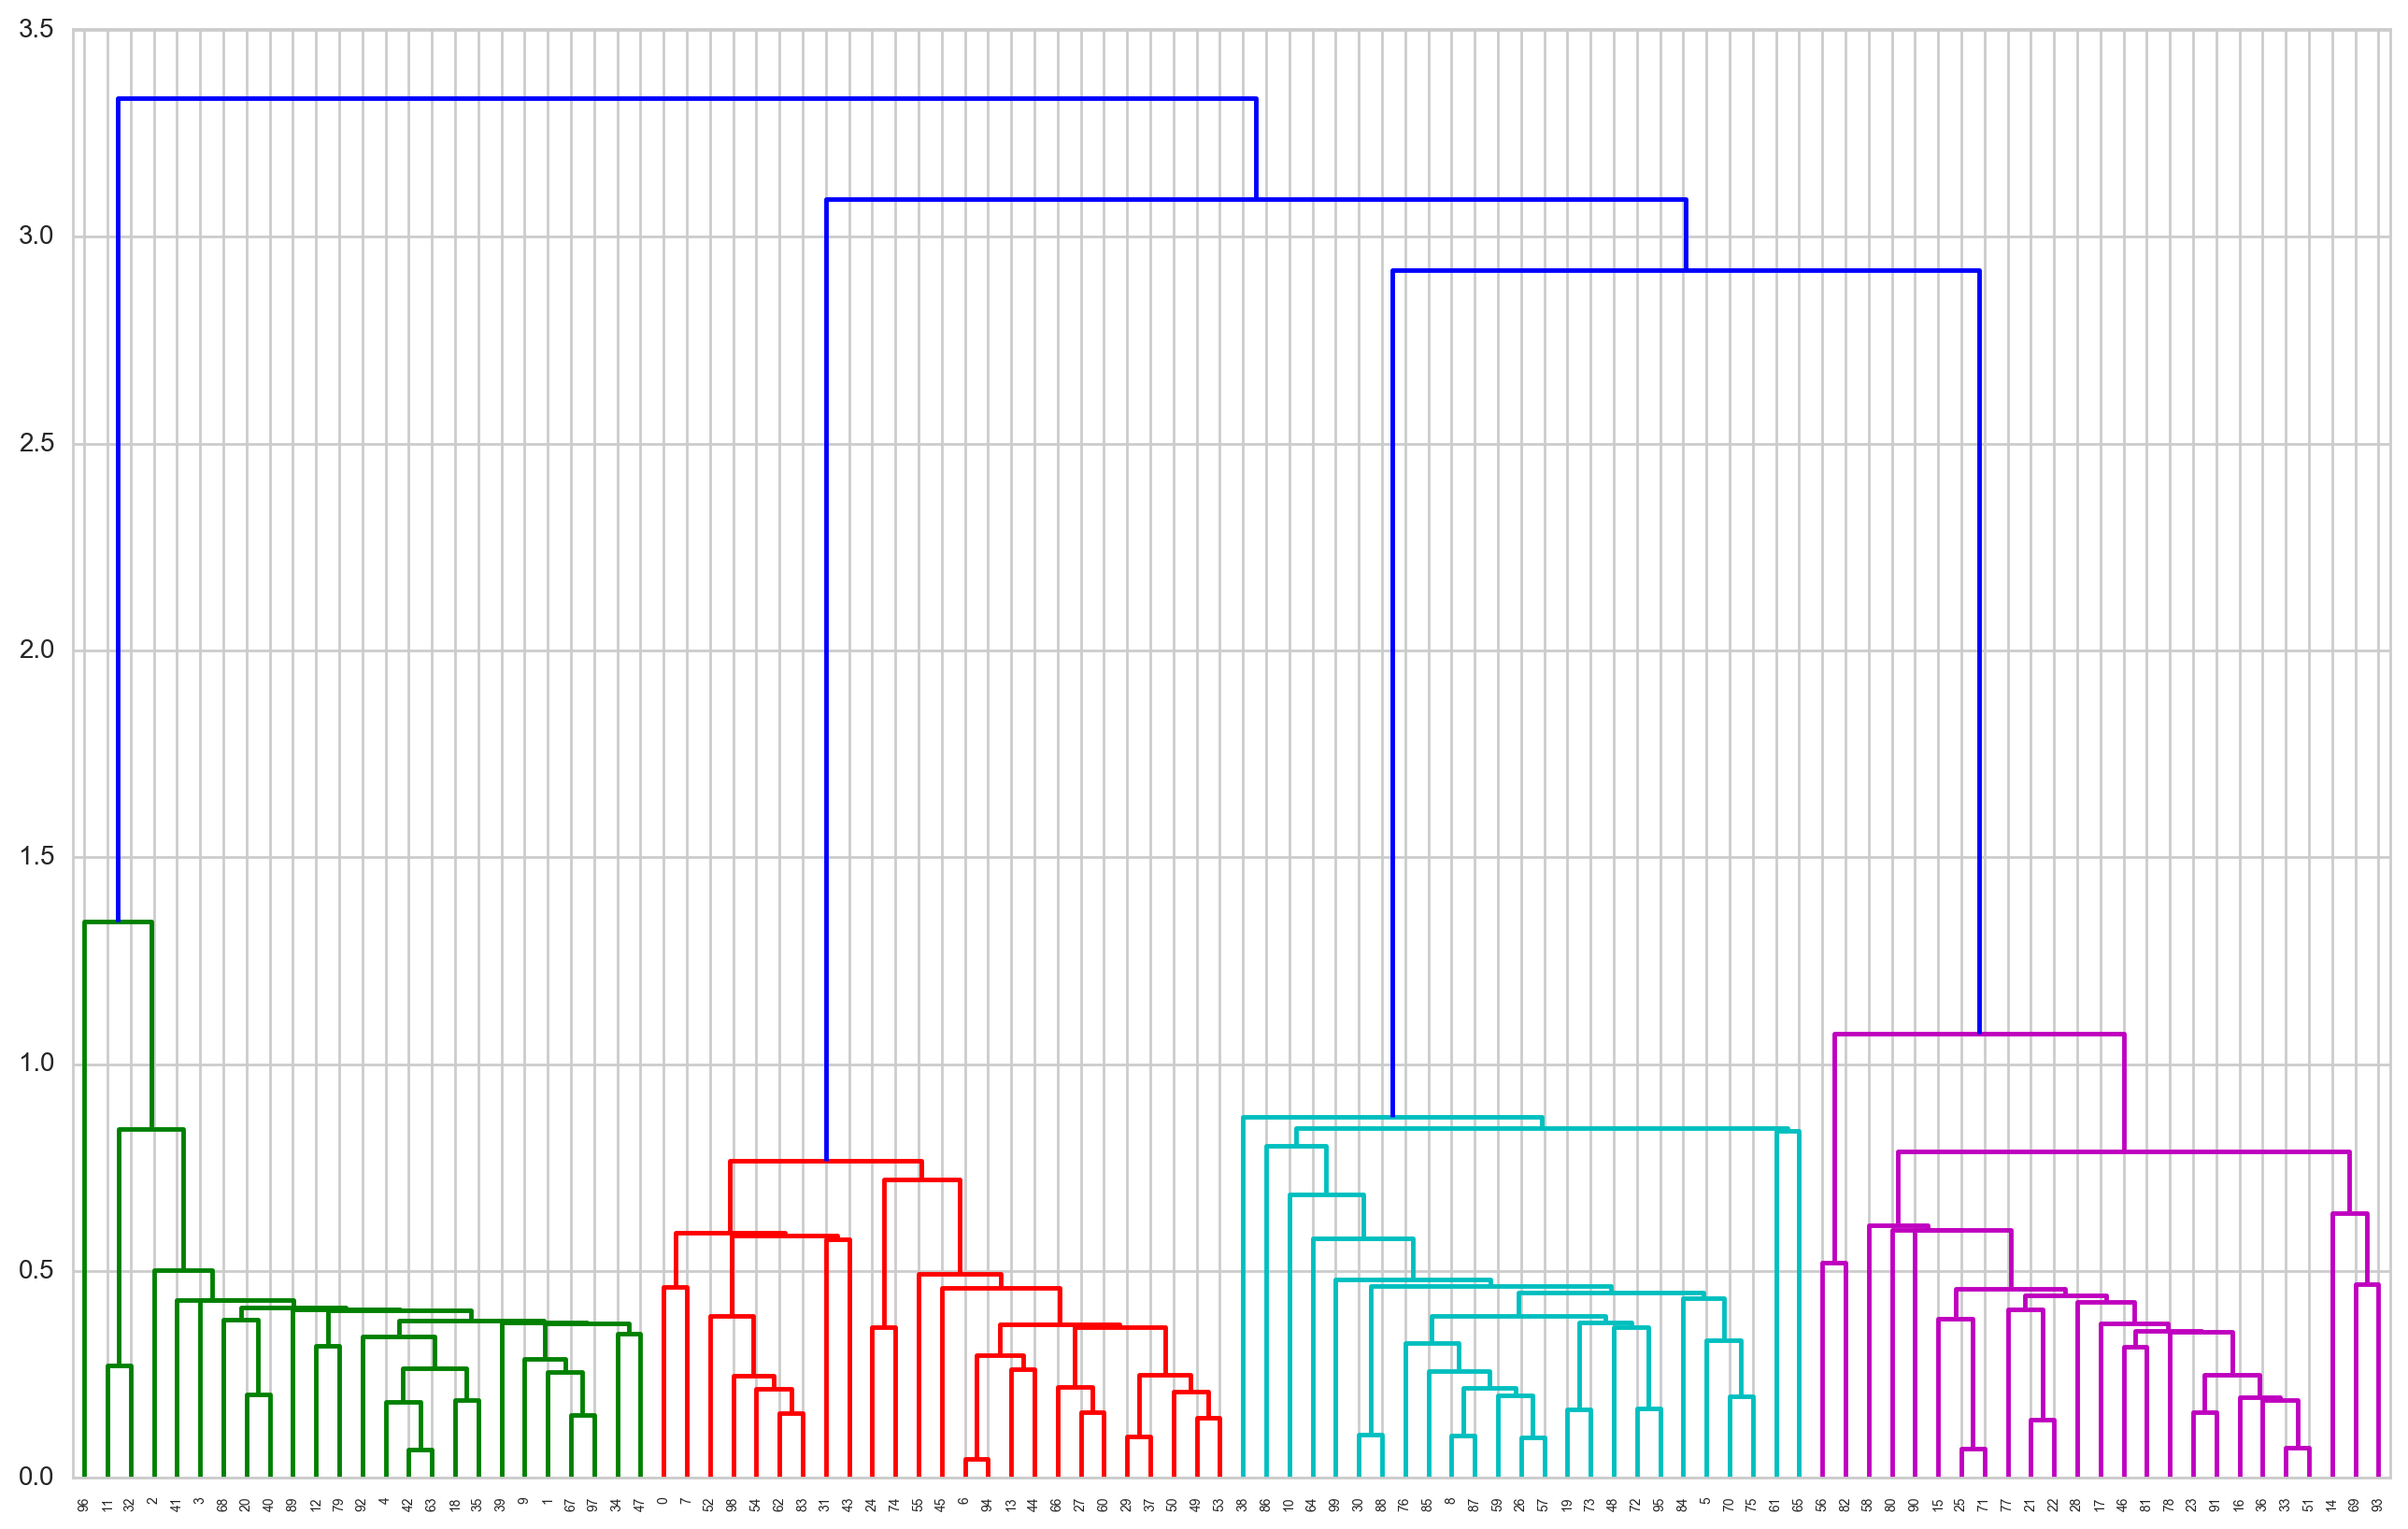

In [607]:
centers = [[-3,3], [3,3], [3,-3], [-3,-3]]
Xdata, _ = make_blobs(n_samples=100, centers=centers, cluster_std=0.7)

draw_dendro(Xdata)